In [1]:
# Multiple plot function yes very interesting
#
# ggplot objects can be passed in ..., or to plotlist (as a list of ggplot objects)
# - cols:   Number of columns in layout
# - layout: A matrix specifying the layout. If present, 'cols' is ignored.
#
# If the layout is something like matrix(c(1,2,3,3), nrow=2, byrow=TRUE),
# then plot 1 will go in the upper left, 2 will go in the upper right, and
# 3 will go all the way across the bottom.
#
multiplot <- function(..., plotlist=NULL, file, cols=1, layout=NULL) {
  library(grid)

  # Make a list from the ... arguments and plotlist
  plots <- c(list(...), plotlist)

  numPlots = length(plots)

  # If layout is NULL, then use 'cols' to determine layout
  if (is.null(layout)) {
    # Make the panel
    # ncol: Number of columns of plots
    # nrow: Number of rows needed, calculated from # of cols
    layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                    ncol = cols, nrow = ceiling(numPlots/cols))
  }

 if (numPlots==1) {
    print(plots[[1]])

  } else {
    # Set up the page
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

    # Make each plot, in the correct location
    for (i in 1:numPlots) {
      # Get the i,j matrix positions of the regions that contain this subplot
      matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

      print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                      layout.pos.col = matchidx$col))
    }
  }
}



<center>

<h1>Modellazione Dataset Housing-Markets</h1>
<h2>Statistical Inference 2016/2017 </h2>
<br />
<br />
<h5>Studente: Francesco Pelosin</h5>
<h5>Matricola: 839220</h5>
<h5>e-mail: 839220@stud.unive.it</h5>
</center>



## 1. Preprocessing

La prima cosa da fare è uno step di preprocessing dove cerchiamo **valori mancanti**, **modifichiamo colonne** e facciamo tutte quelle operazioni che riguardano i dati puri.

Il dataset è composto come segue:

1. `price`: Prezzo della casa in 100 \$ dollari (**Variabile risposta**)
2. `dimension`: Dimensione della casa in piedi quadri (**Predittore quantitativo**)
3. `score`: Valutazione da 0 a 10 data da un esperto del settore (**Predittore categoriale**)
4. `city.center`: Variabile sì/no, "la casa è in centro città?" (**Predittore categoriale**)
5. `traditional`: Variabile sì/no, "la casa è stile tradizionale?"  (**Predittore categoriale**)
6. `garage`: Variabile sì/no, "la casa dispone di un garage?" (**Predittore categoriale**)

In [2]:
oldw <- getOption("warn")
options(warn = -1)

In [3]:
markets <- read.csv("Housing-Market.csv")
head(markets)

,price,dimension,score,city.center,traditional,garage
1,947,1142,4,no,no,no
2,654,768,2,no,no,no
3,875,1173,4,yes,no,no
4,1125,1710,4,yes,yes,no
5,665,1407,4,no,no,no
6,855,1900,3,yes,no,no


In [4]:
options(warn = oldw)

Iniziamo subito cercando eventuali **valori mancanti** nel dataset:

In [5]:
sapply(markets, function(x) sum(is.na(x)))

price   dimension       score city.center traditional      garage 
          0           0           0           0           0           0

Come si può vedere **non ci sono valori mancanti** in quanto nessuna colonna contiene valori `NA`.

Per rendere l'analisi **più interpretabile** e fruibile a noi (non americani), convertiamo la scala della variabile `dimension` **da  piedi² a metri²**. In questo modo risciamo ad avere una interpretazione più intuitiva durante l'analisi.

> Perderemo il valore arrotondato, ma non è un gran problema per R

Inoltre passiamo **da centinaia di dollari in dollari** standard.

In [6]:
markets$dimension <- markets$dimension * 0.09290304
markets$price <- markets$price * 100
head(markets)

,price,dimension,score,city.center,traditional,garage
1,94700,106.09527168,4,no,no,no
2,65400,71.34953472,2,no,no,no
3,87500,108.97526592,4,yes,no,no
4,112500,158.8641984,4,yes,yes,no
5,66500,130.71457728,4,no,no,no
6,85500,176.515776,3,yes,no,no


In [7]:
summary(markets)

     price          dimension          score       city.center traditional
 Min.   : 54000   Min.   : 70.98   Min.   :0.000   no : 59     no :130    
 1st Qu.: 79850   1st Qu.:112.55   1st Qu.:3.000   yes:108     yes: 37    
 Median : 97200   Median :136.20   Median :4.000                          
 Mean   :105350   Mean   :146.55   Mean   :3.509                          
 3rd Qu.:116500   3rd Qu.:167.41   3rd Qu.:4.000                          
 Max.   :216900   Max.   :348.39   Max.   :8.000                          
 garage   
 no :136  
 yes: 31  
          
          
          
          

Come si può vedere dal summary `score` **non viene considerato un predittore categoriale**. 

Forziamo R ad **interpretarlo come tale** attraverso l a funzione `factor`.

In [8]:
markets$score <- factor(markets$score, labels = c("0","1","2","3","4","5","6","7","8"))
summary(markets)

     price          dimension          score    city.center traditional
 Min.   : 54000   Min.   : 70.98   4      :60   no : 59     no :130    
 1st Qu.: 79850   1st Qu.:112.55   3      :39   yes:108     yes: 37    
 Median : 97200   Median :136.20   2      :26                          
 Mean   :105350   Mean   :146.55   5      :17                          
 3rd Qu.:116500   3rd Qu.:167.41   6      :10                          
 Max.   :216900   Max.   :348.39   1      : 9                          
                                   (Other): 6                          
 garage   
 no :136  
 yes: 31  
          
          
          
          
          

## 2. Exploratory Data Analysis

Ora siamo pronti per iniziare la seconda fase (EDA) per estrapolare **informazioni preliminari**, **visualizzare relazioni** tra predittori e la variabile risposta, **identificazione degli outliers** e farci una idea di che tipo di **predittori potremmo includere** nel modello.

La prima cosa che ho notato con il summary è che:

* *Il  numero delle case senza garage è quasi uguale al unmero di case che non sono tradizionali*

````
        traditional    garage
        no :130        no :136   
        yes: 37        yes: 31 
````

Controlliamo se c'è una qualsiasi relazione tra queste due variabili. Se così fosse vremmo due variabili che portano la **stessa informazione** e potremmo rimuoverne una

In [9]:
options(repr.plot.width=4, repr.plot.height=3)

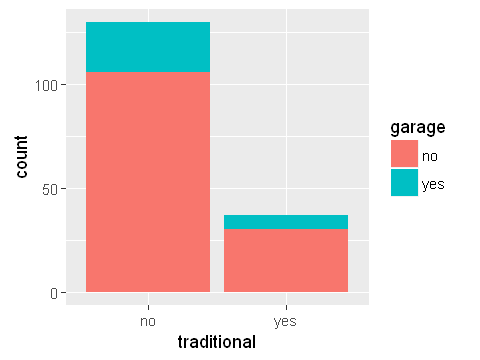

In [10]:
library(ggplot2) # Libreria grafica ggplot2

ggplot(markets, aes(x=traditional, fill=garage))+
geom_bar()


Il grafico dimostra che **non è il caso**, ci sono più case con il garage (plausibile) per entrambi i tipi di casa.

Il prossimo grafico a dispersione (**scatter plot**) riguarda l'unica variabile quantitativa `dimension` in relazione con `price`.

Quello che personalmente mi aspetto è che:

- *Più aumenta la grandezza di una casa, più aumenta il prezzo*

Vediamo difatti la loro **correlazione lineare**:

$$ Cor(\texttt{dimension}, \texttt{price})$$

In [11]:
with(markets, round(cor(price,dimension),2))

[1] 0.81

Infatti il coefficiente è alto **come ci aspettavamo**. Sicuramente questo predittore potrà essere parte del nostro modello, ora vediamo il grafico.

In [12]:
options(repr.plot.width=4, repr.plot.height=4)

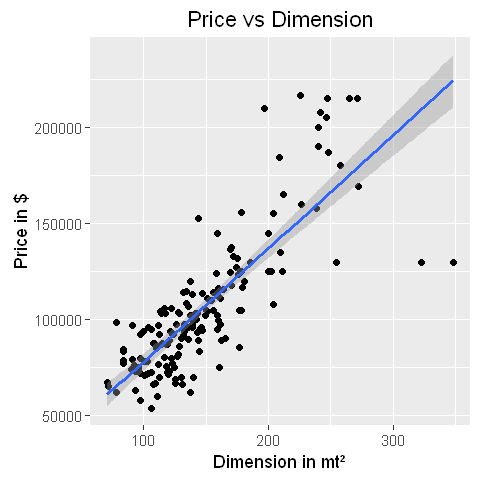

In [13]:
ggplot(markets, aes(x=dimension, y=price)) + 
    geom_point(shape=16) + 
    geom_smooth(method=lm) + # Retta di regressione (default 95% reg. di conf.)
    ggtitle("Price vs Dimension")+
    xlab("Dimension in mt²")+
    ylab("Price in $")

Osservazioni:

1. La prima cosa da notare è che ci sono **due outliers**, sono due case con dimensione maggiore di 300 mt²

2. La relazione con il prezzo **non sembra totalmente lineare** forse un termine quadratico potrebbe modellare meglio l'approssimazone.

Identifichiamo gli outliers e salviamoli in `markets.outliers`.

In [14]:
subset(markets, dimension > 300) # Per visualizzare la tebellina
markets.outliers <- which(markets$dimension > 300)

,price,dimension,score,city.center,traditional,garage
81,129900,322.46645184,4,no,yes,yes
92,129500,348.3864,4,no,yes,yes


Prima di decidere cosa fare, vediamo altri grafici delle restanti variabili.

Ora abbiamo solo **predditori categoriali**, in questo caso *non si puo calcolare la correlazione* per tanto utilizzeremo dei **box plots** per analizzare i dati. 

Quello che personalmente mi aspetto è:

- *`garage` credo influirà molto nel prezzo della casa (anche se in parte l'informazione potrebbe essere nella variabile dimensione)*

- *`city.center` credo influirà molto nel prezzo della casa*

- *`traditional` non credo influirà più di tanto nella variabile risposta*

- *`score` non credo influirà più di tanto in quanto l'esperto potrebbe essere "biased" e dare giudizi non oggettivi in quanto influenzato dalla suoi gusti ed esperienze personali.*

In [15]:
options(repr.plot.width=6, repr.plot.height=4)

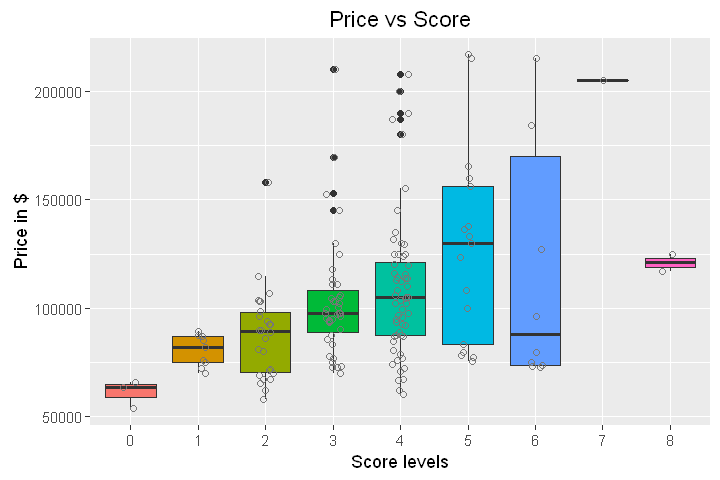

In [16]:
ggplot(markets, aes(x=score, y=price, fill=score)) + 
    geom_boxplot() + 
    geom_jitter(shape=1, position=position_jitter(0.3), color="#777777")+
    theme(legend.position="none")+
    ggtitle("Price vs Score")+
    xlab("Score levels")+
    ylab("Price in $")

Osservazioni:

- Come lo score cresce, la variabilità cresce significativamente
- Ci sono parecchie case che hanno lo stesso score
- Sembra esserci una sorta di relazione tra lo score ed il prezzo, ma non è molto chiara

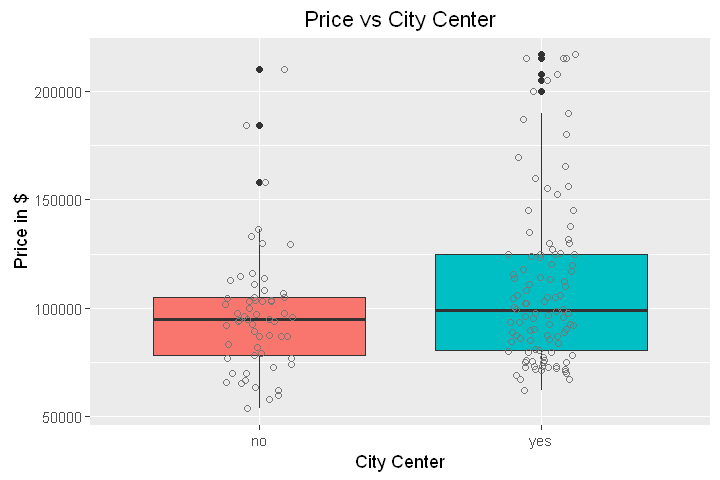

In [17]:
ggplot(markets, aes(x=city.center, y=price, fill=city.center)) + 
    geom_boxplot() + 
    geom_jitter(shape=1, position=position_jitter(0.3), color="#777777")+
    theme(legend.position="none")+
    ggtitle("Price vs City Center")+
    xlab("City Center")+
    ylab("Price in $")

Osservazioni:

- Le case che non sono in centro città costano un po' di meno
- In centro città ci sono più case, molte costano poco (probabilmente sono appartamenti condominiali)

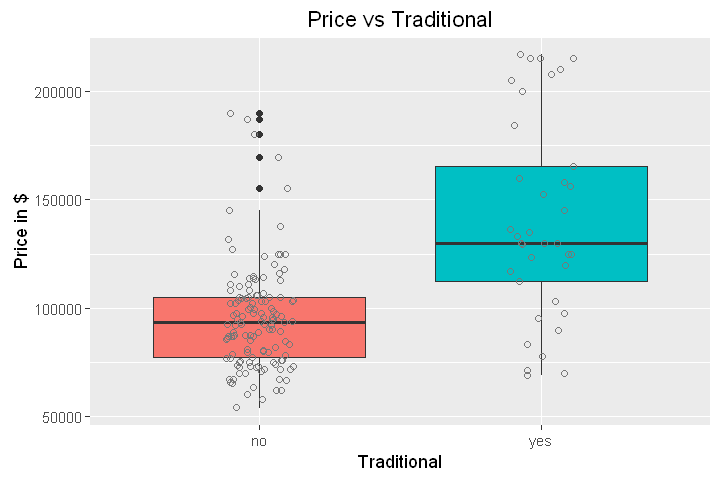

In [18]:
ggplot(markets, aes(x=traditional, y=price, fill=traditional)) + 
    geom_boxplot() + 
    geom_jitter(shape=1, position=position_jitter(0.3), color="#777777")+
    theme(legend.position="none")+
    ggtitle("Price vs Traditional")+
    xlab("Traditional")+
    ylab("Price in $")

Osservazioni:

- Le case moderne tendono a costare di più rispetto alle tradizionali
- Le case non tradizionali hanno prezzi molto più variabili

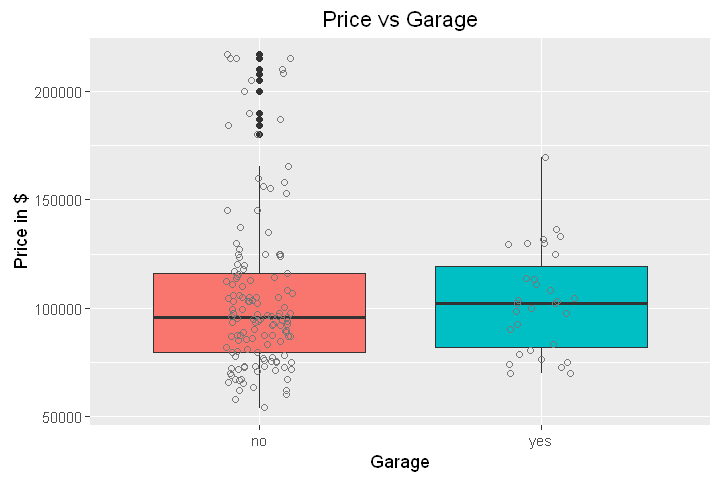

In [19]:
ggplot(markets, aes(x=garage, y=price, fill=garage)) + 
    geom_boxplot() + 
    geom_jitter(shape=1, position=position_jitter(0.3), color="#777777")+
    theme(legend.position="none")+
    ggtitle("Price vs Garage")+
    xlab("Garage")+
    ylab("Price in $")


Osservazioni:

- Non vi sono particolari informazioni 
  

Proviamo ora a comparare il predittore dimensione con i predittori categoriali.

In [20]:
options(repr.plot.width=8, repr.plot.height=5)

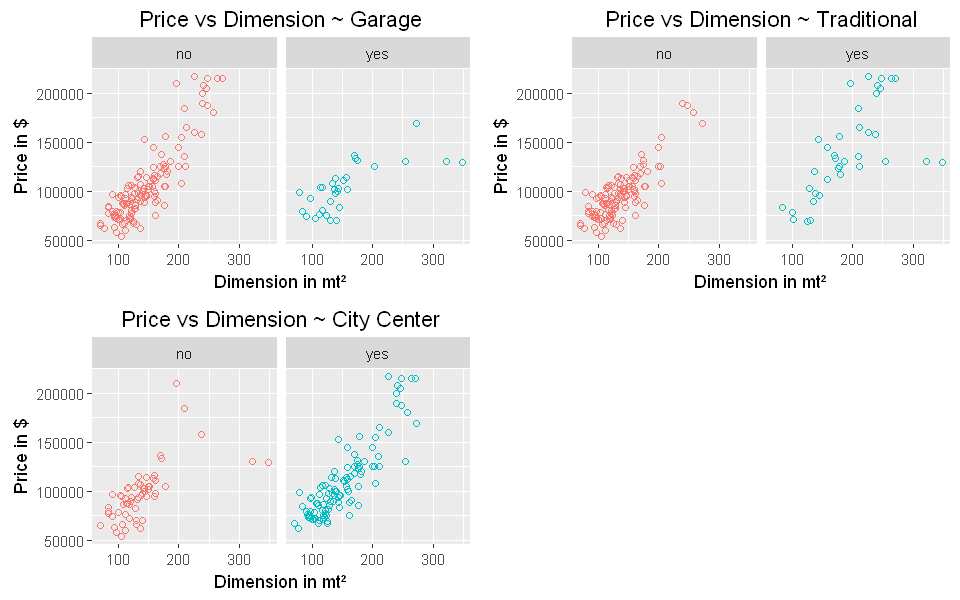

In [21]:
p1 <- ggplot(markets, aes(x=dimension, y=price,color=garage)) +
    theme(legend.position="none")+
    geom_point(shape=1)+facet_wrap(~garage)+ylab("Price in $")+ 
    ggtitle("Price vs Dimension ~ Garage")+xlab("Dimension in mt²")

p2 <- ggplot(markets, aes(x=dimension, y=price,color=city.center)) +
    theme(legend.position="none")+
    geom_point(shape=1)+ylab("Price in $")+xlab("Dimension in mt²")+
    facet_wrap(~city.center)+ggtitle("Price vs Dimension ~ City Center")
    
p3 <- ggplot(markets, aes(x=dimension, y=price, color=traditional)) +
    theme(legend.position="none")+
    geom_point(shape=1)+facet_wrap(~traditional)+ylab("Price in $")+
    ggtitle("Price vs Dimension ~ Traditional")+xlab("Dimension in mt²")
   
multiplot(p1,p2,p3, cols=2)

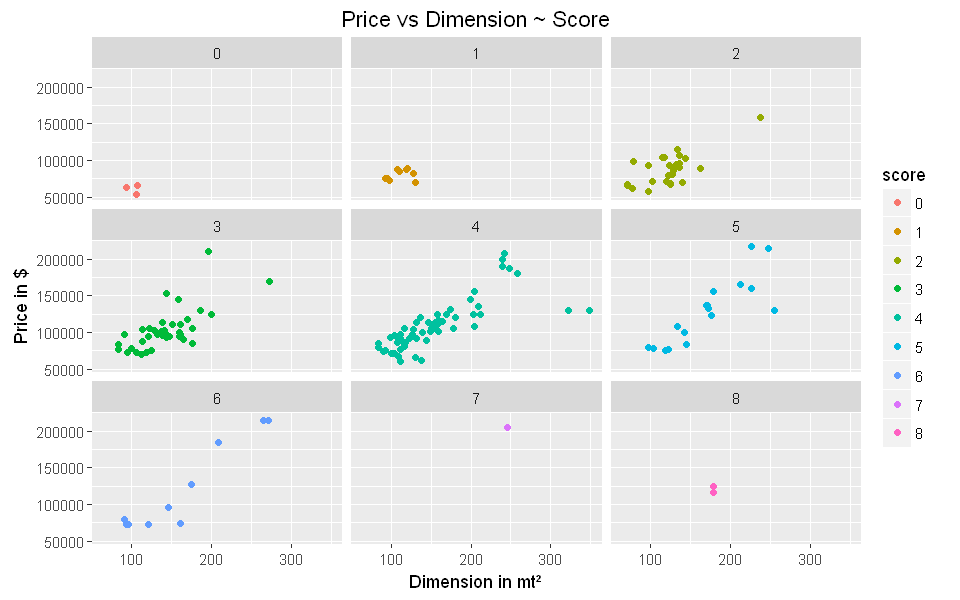

In [22]:
ggplot(markets,aes(x=dimension, y=price, color=score)) + 
    coord_cartesian( xlim = c(65, 350), ylim = c(54000, 216900)) + 
    geom_point(shape=16) + facet_wrap(~score) + 
    ggtitle("Price vs Dimension ~ Score")+xlab("Dimension in mt²") + ylab("Price in $")

As can be seen there is nothing exremely informative with these plots. The only thing that is remarkable is that the two **outliers should be removed** since I suspect they **will have a bad influence on the predictions**.

## 3. Creazione Modello

In questa parte si proverà a creare il nostro modello statistico che cercherà di **descrivere il fenomeno** catturato nel dataset. Inizierò con un modello semplice fino ad arrivare a quello scelto. 

### Modello Lineare con Outliers

<br>

$$Y= \beta_0 + \beta_1 X_1+\epsilon $$

Dove:

- $Y$ corrisponde a `price`
- $X_1$ corrisponde a `dimension`

In [23]:
mod_a <- lm(price ~ dimension, data=markets)
summary(mod_a)


Call:
lm(formula = price ~ dimension, data = markets)

Residuals:
   Min     1Q Median     3Q    Max 
-94756 -10415   -299   9252  75176 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 19011.51    5144.50   3.696 0.000298 ***
dimension     589.13      33.29  17.695  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 21070 on 165 degrees of freedom
Multiple R-squared:  0.6549,	Adjusted R-squared:  0.6528 
F-statistic: 313.1 on 1 and 165 DF,  p-value: < 2.2e-16


In [24]:
options(repr.plot.width=8, repr.plot.height=4)
oldw <- getOption("warn")
options(warn = -1)

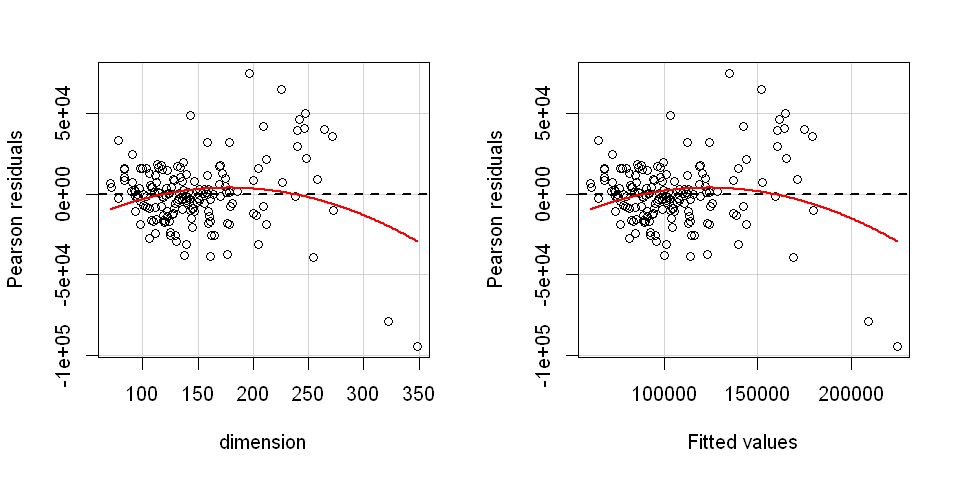

In [25]:
library(car)
residualPlots(mod_a,test=FALSE)

[1] 1 2

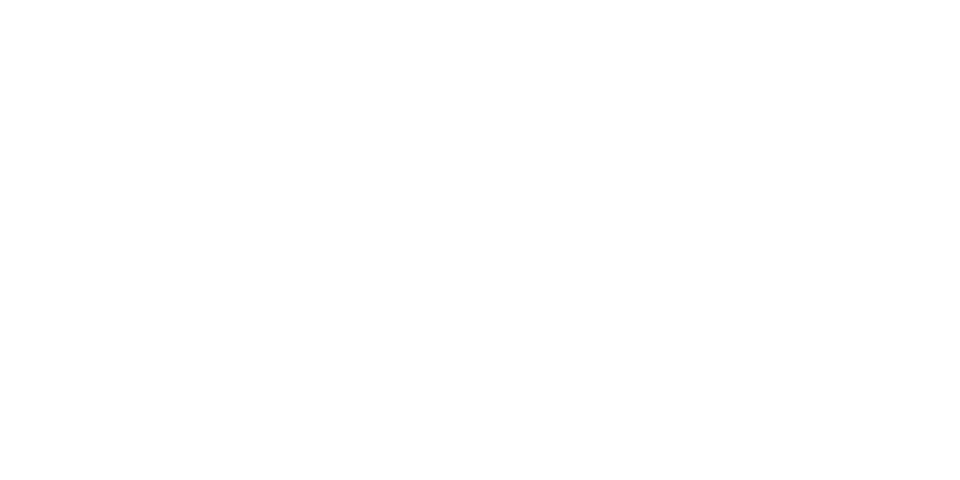

In [26]:
options(repr.plot.width=8, repr.plot.height=4) 
oldw <- getOption("warn")
options(warn = -1)
split.screen(c(1, 2))

[1] 3 4

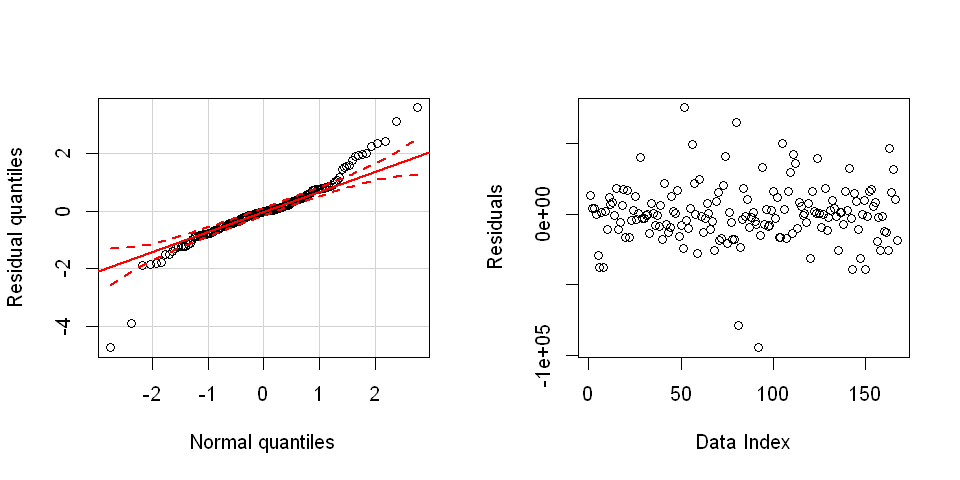

In [27]:
split.screen(c(1, 2))

screen(1)
qqPlot(rstandard(mod_a), xlab = "Normal quantiles", ylab = "Residual quantiles")

screen(2)
plot(residuals(mod_a),xlab = "Data Index", ylab = "Residuals")

In [28]:
options(warn = oldw)

Il modello è molto semplice e facile da **interpretare**:

$$\texttt{price} = 19012 + 589*\texttt{dimension}+\epsilon $$

Ci sono dei **problemi evidenti**:

- Gli outliers hanno un forte impatto nel modello. 
- Nel grafico residui vs dimensione possiamo notare che non vi è una relazione lineare
- Il `qqplot` è disastroso

Proviamo a sistemare i primi due problemi.

## Modello Quadratico senza Outliers

<br>

$$Y= \beta_0 + \beta_1 X^2_1+\epsilon $$

Dove:

- $Y$ corrisponde a `price`
- $X_1$ corrisponde a `dimension`

In [29]:
mod_b <- lm(price ~ I(dimension^2) , data=markets, subset=-markets.outliers)
summary(mod_b)


Call:
lm(formula = price ~ I(dimension^2), data = markets, subset = -markets.outliers)

Residuals:
   Min     1Q Median     3Q    Max 
-63187  -8659    191  10243  71843 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)    5.743e+04  2.482e+03   23.14   <2e-16 ***
I(dimension^2) 2.089e+00  9.101e-02   22.95   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 17490 on 163 degrees of freedom
Multiple R-squared:  0.7637,	Adjusted R-squared:  0.7623 
F-statistic: 526.8 on 1 and 163 DF,  p-value: < 2.2e-16


In [30]:
options(repr.plot.width=8, repr.plot.height=4)

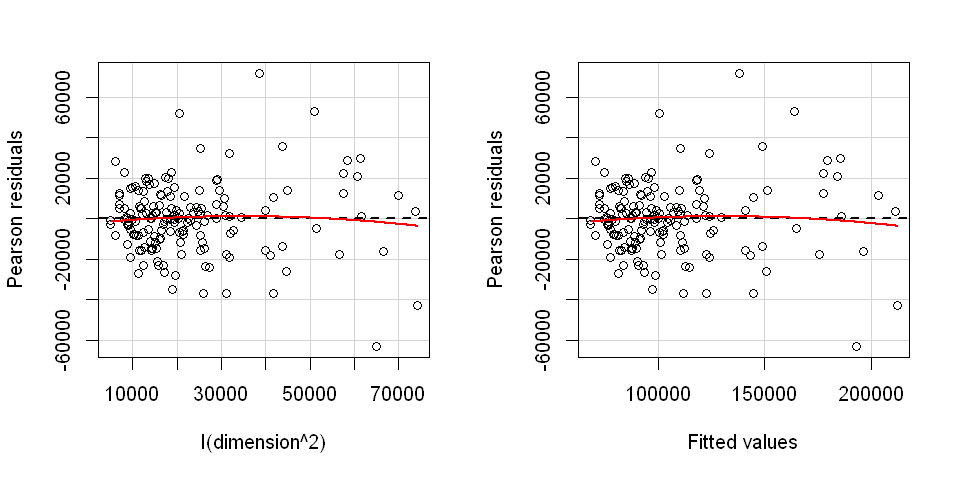

In [31]:
residualPlots(mod_b,test=FALSE)

[1] 5 6

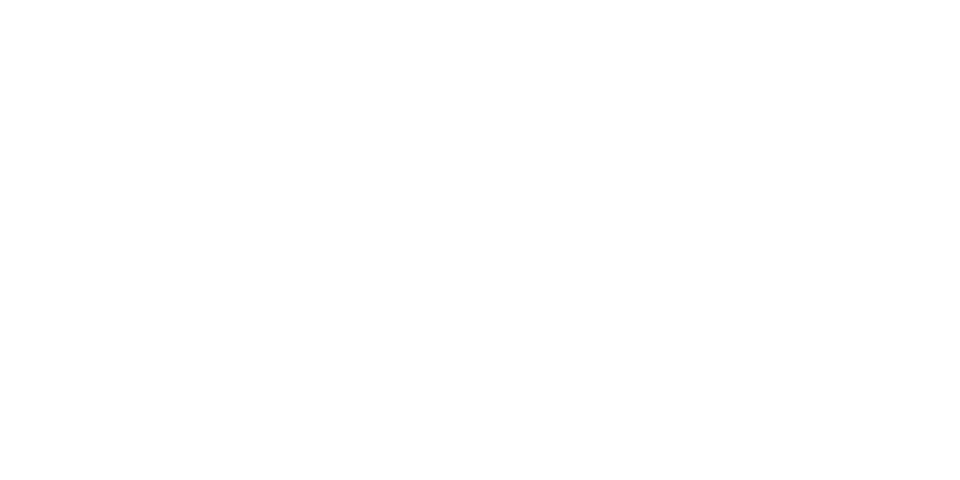

In [32]:
options(repr.plot.width=8, repr.plot.height=4) 
oldw <- getOption("warn")
options(warn = -1)
split.screen(c(1, 2))

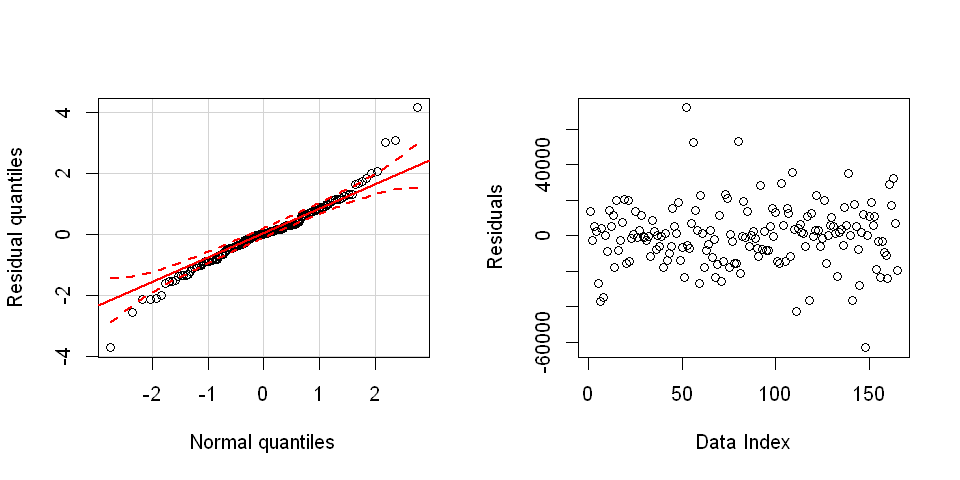

In [33]:
screen(1)
qqPlot(rstandard(mod_b), xlab = "Normal quantiles", ylab = "Residual quantiles")

screen(2)
plot(residuals(mod_b),xlab = "Data Index", ylab = "Residuals")

In [34]:
options(warn = oldw)

## Modelli candidati

### Modello 1

<br>

$$Y= \beta_0 + \beta_1 X^2_1 + \beta_2 X_2+\epsilon $$

Dove:

- $Y$ corrisponde a `price` 
- $X_1$ corrisponde a `dimension`.
- $X_2$ corrisponde a `traditional`.

In [35]:
mod1 <- lm(price ~ I(dimension^2) + traditional  , data=markets, subset=-markets.outliers)
summary(mod1)


Call:
lm(formula = price ~ I(dimension^2) + traditional, data = markets, 
    subset = -markets.outliers)

Residuals:
   Min     1Q Median     3Q    Max 
-66649  -9912    984   9128  63826 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)    5.848e+04  2.403e+03  24.339  < 2e-16 ***
I(dimension^2) 1.916e+00  9.880e-02  19.390  < 2e-16 ***
traditionalyes 1.366e+04  3.616e+03   3.778 0.000222 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 16820 on 162 degrees of freedom
Multiple R-squared:  0.7828,	Adjusted R-squared:  0.7802 
F-statistic:   292 on 2 and 162 DF,  p-value: < 2.2e-16



Se la casa è tradizionale:

$$ \texttt{price} = (5848+ 1.366) + 1.916*\texttt{dimension}^2 +\epsilon $$

altrimenti:

$$ \texttt{price} = 5848 + 1.916*\texttt{dimension}^2 +\epsilon $$


In [36]:
options(repr.plot.width=8, repr.plot.height=7)

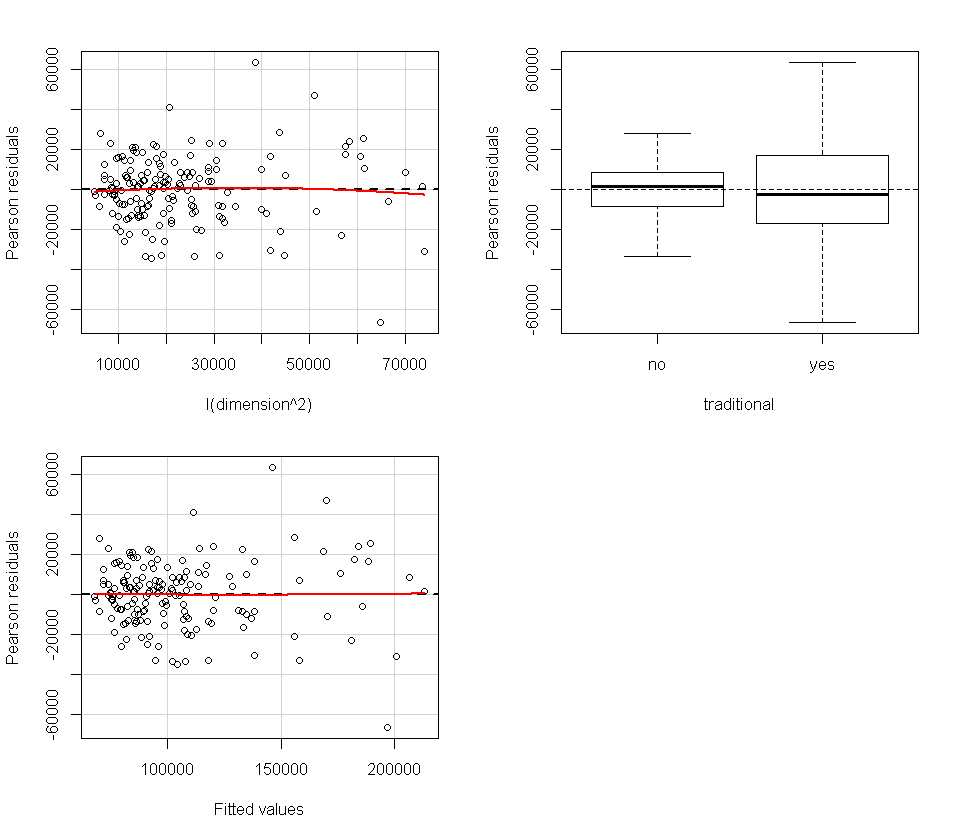

In [37]:
residualPlots(mod1,test=FALSE)

[1] 7 8

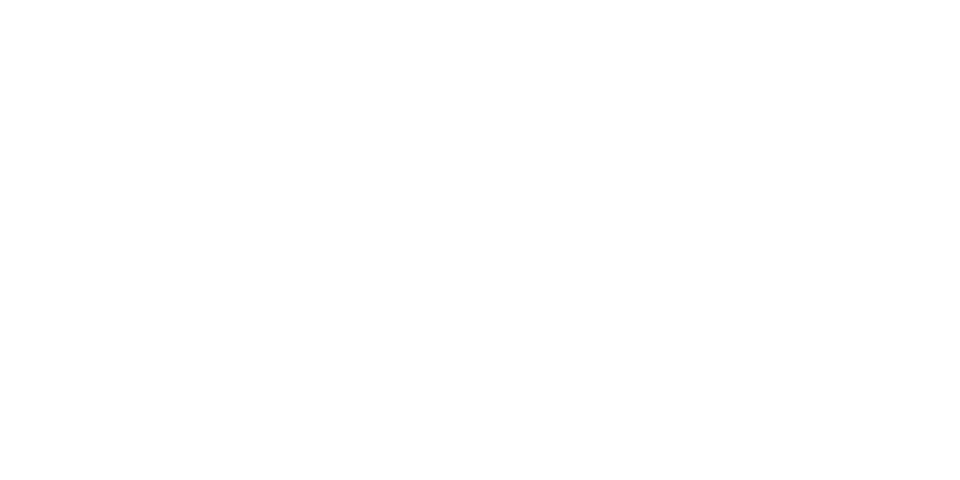

In [38]:
options(repr.plot.width=8, repr.plot.height=4) 
oldw <- getOption("warn")
options(warn = -1)
split.screen(c(1, 2))

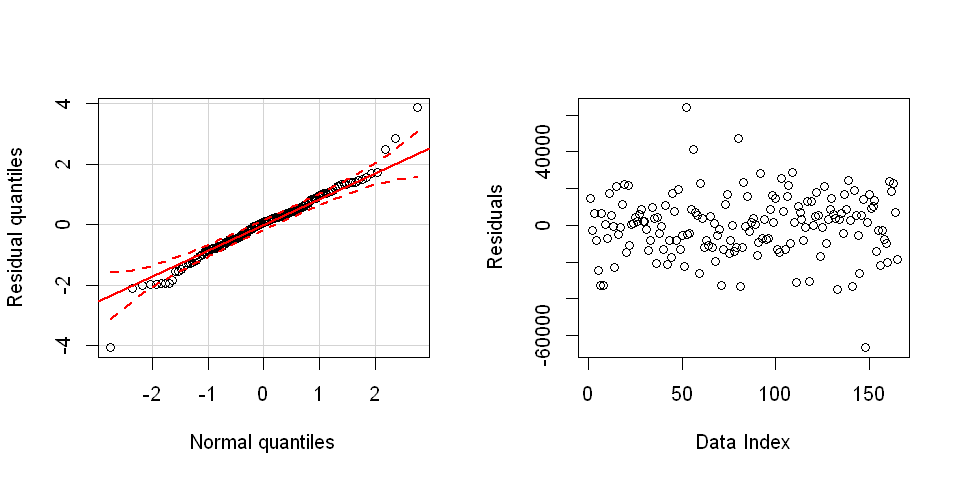

In [39]:
screen(1)
qqPlot(rstandard(mod1), xlab = "Normal quantiles", ylab = "Residual quantiles")

screen(2)
plot(residuals(mod1),xlab = "Data Index", ylab = "Residuals")

In [40]:
options(warn = oldw)

### Modello 2 : 

<br>

$$Y= \beta_0 + \beta_1 X^2_1 + \beta_2 X_2 + \beta_3 X_3 + \beta_4 X_2X_3 +\epsilon$$

Dove:

- $Y$ corrisponde a `price` 
- $X_1$ corrisponde a `dimension`.
- $X_2$ corrisponde a `traditional`.
- $X_3$ corrisponde a `garage`.

In [41]:
mod2 <- lm(price ~ I(dimension^2) + traditional*garage  , data=markets, subset=-markets.outliers)
summary(mod2)


Call:
lm(formula = price ~ I(dimension^2) + traditional * garage, data = markets, 
    subset = -markets.outliers)

Residuals:
   Min     1Q Median     3Q    Max 
-46067 -11393   1259  10143  60534 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)               5.837e+04  2.438e+03  23.943  < 2e-16 ***
I(dimension^2)            1.897e+00  9.693e-02  19.566  < 2e-16 ***
traditionalyes            1.780e+04  3.821e+03   4.659 6.64e-06 ***
garageyes                 2.594e+03  3.723e+03   0.697  0.48697    
traditionalyes:garageyes -2.596e+04  8.800e+03  -2.951  0.00365 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 16460 on 160 degrees of freedom
Multiple R-squared:  0.7945,	Adjusted R-squared:  0.7894 
F-statistic: 154.7 on 4 and 160 DF,  p-value: < 2.2e-16


In [42]:
options(repr.plot.width=8, repr.plot.height=7)

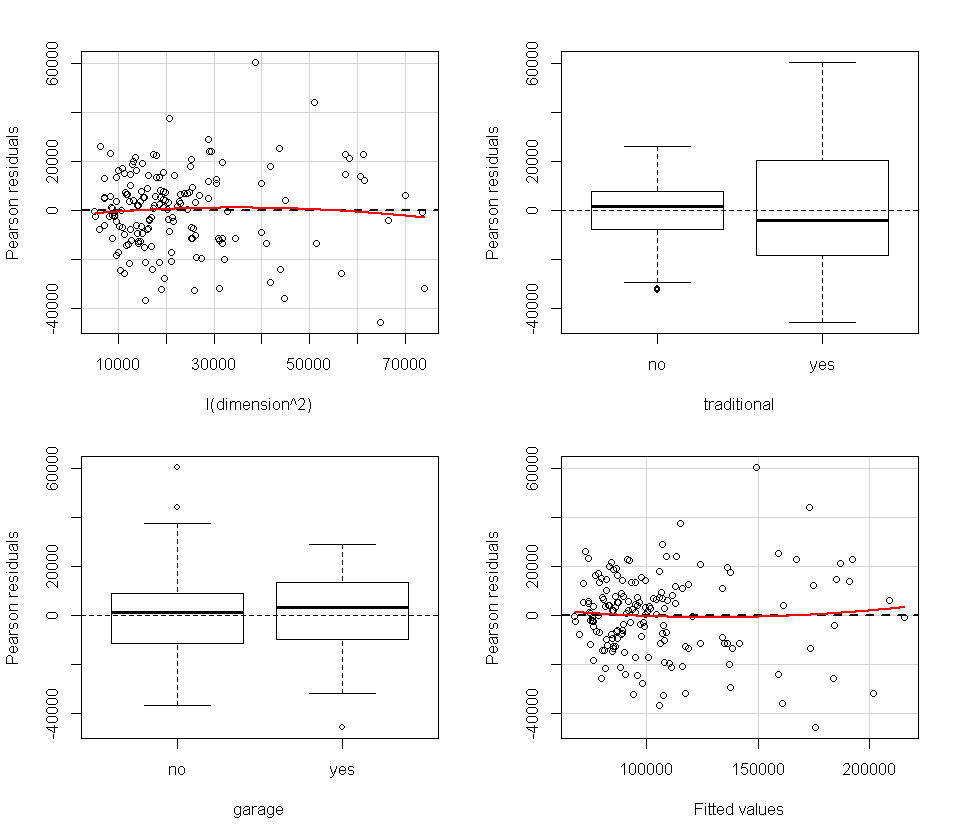

In [43]:
residualPlots(mod2,test=FALSE)

[1]  9 10

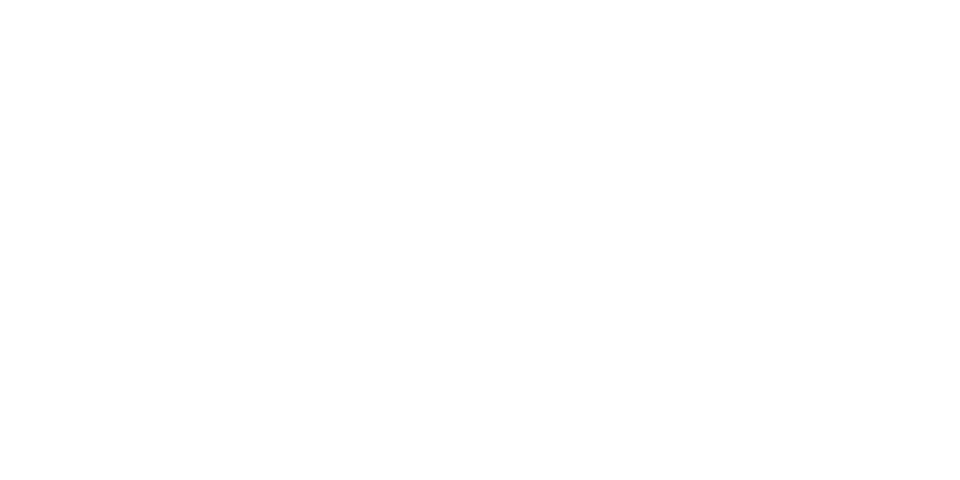

In [44]:
options(repr.plot.width=8, repr.plot.height=4) 
oldw <- getOption("warn")
options(warn = -1)
split.screen(c(1, 2))


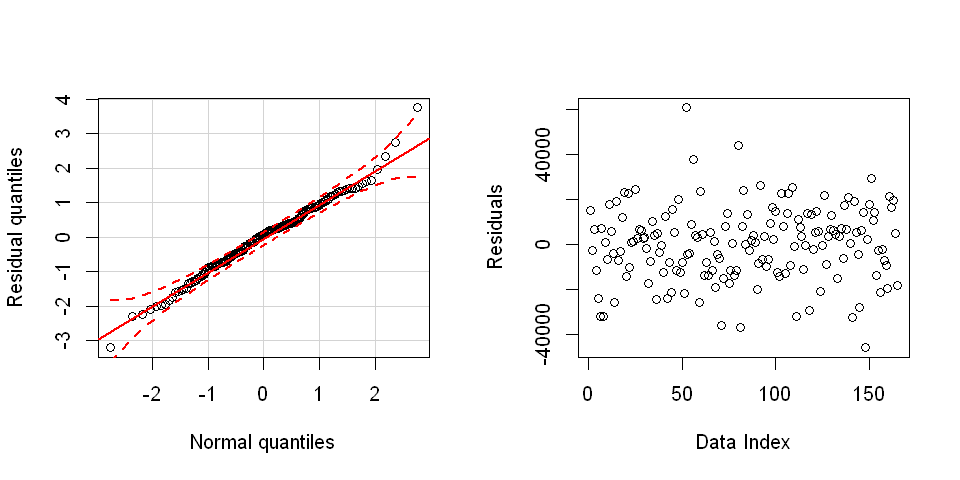

In [45]:
screen(1)
qqPlot(rstandard(mod2), xlab = "Normal quantiles", ylab = "Residual quantiles")

screen(2)
plot(residuals(mod2),xlab = "Data Index", ylab = "Residuals")

In [46]:
options(warn = oldw)

Sono stati trovati diversi modelli con migliori $R^2_{adj}$, ma la preferenza è ricaduta su un **modello più semplice** anzichè più complesso.

````r
model <- lm(price ~ dimension*garage*traditional*city.center*score, data=markets, subset=-markets.outliers)
````

Come si può intuire questo modello non è per niente semplice per questo è stato scartato.

## 4. Validation

In questo step valideremo il modello creato, facendo delle **previsioni** di prezzi di case. In questo modo potremmo capire quanto sia efficace il nostro modello.

Ho usato la tecnica della **cross validation** per generare e testare il modello 

![xval](xval.png)

Per prima cosa **randomizzo i dati** in modo da rimuovere qualsiasi ordine dei dati, questo serve ad uniformare il più possibile le istanze.

In [47]:
#Randomly shuffle the data
markets.nout <- markets[-markets.outliers,]

markets.nout<-markets.nout[sample(nrow(markets.nout)),]

In [48]:
all_errors <- c()
all_sderrors <- c()
all_rsq <- c()


# Creazione dei training-test sets
folds <- cut(seq(1,nrow(markets.nout)),breaks=10,labels=FALSE)

for(i in 1:10){
    
    # Segmentazione dataset
    testIndexes <- which(folds==i,arr.ind=TRUE)
    testData <- markets.nout[testIndexes, ]
    trainData <- markets.nout[-testIndexes, ]
    
    # Modello
    mod2 <- lm(price ~ I(dimension^2) + garage*traditional , data=trainData)
    rsq <- summary(mod2)$adj.r.square
    
    # Previsioni
    pred <- predict(mod2, newdata=testData)
    error <- pred-testData$price
    
    # Debug
    cat(sprintf("\n--------------------- Modello %d -----------------------\n", i))
    cat(sprintf("R^2 in Training: %.3f \n",rsq))
    cat(sprintf("Errore medio in Test: %.3f \n", mean(error)))
    cat(sprintf("Dev. Std. errori in Test: %.3f \n", sd(error)))
    
    
    # Statistiche totali
    all_errors <- c(all_errors, error)
    all_sderrors <- c(all_sderrors, sd(error))
    all_rsq <- c(all_rsq, rsq)
    
}


--------------------- Modello 1 -----------------------
R^2 in Training: 0.801 
Errore medio in Test: 6255.040 
Dev. Std. errori in Test: 19205.485 

--------------------- Modello 2 -----------------------
R^2 in Training: 0.796 
Errore medio in Test: 2051.709 
Dev. Std. errori in Test: 15268.178 

--------------------- Modello 3 -----------------------
R^2 in Training: 0.776 
Errore medio in Test: 3490.589 
Dev. Std. errori in Test: 17862.780 

--------------------- Modello 4 -----------------------
R^2 in Training: 0.787 
Errore medio in Test: -4042.921 
Dev. Std. errori in Test: 10835.263 

--------------------- Modello 5 -----------------------
R^2 in Training: 0.783 
Errore medio in Test: -2518.091 
Dev. Std. errori in Test: 18519.902 

--------------------- Modello 6 -----------------------
R^2 in Training: 0.806 
Errore medio in Test: -10163.102 
Dev. Std. errori in Test: 17916.989 

--------------------- Modello 7 -----------------------
R^2 in Training: 0.776 
Errore medio in

In [49]:
options(repr.plot.width=6, repr.plot.height=4) 

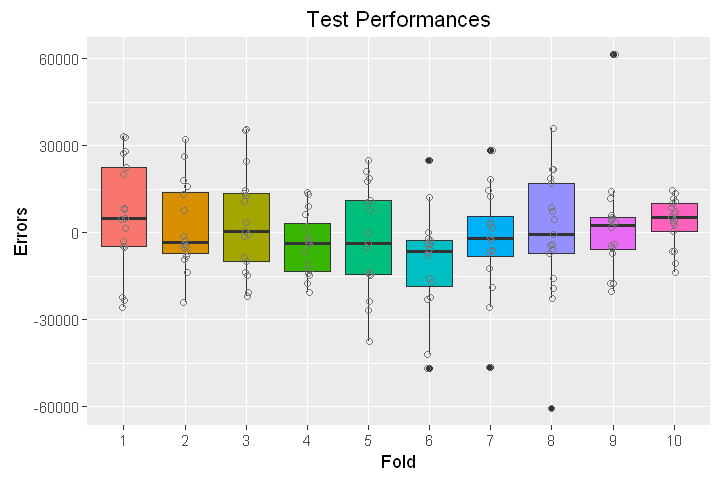

In [50]:
# ggplot richiede un data frame
flds <- factor(folds, labels=c("1","2","3","4","5","6","7","8","9","10"))
aux <- data.frame(all_errors, flds )

ggplot(aux, aes(x= flds, y=all_errors, fill=flds))+
  geom_boxplot()+
  geom_jitter(shape=1, position=position_jitter(0.1), color="#777777")+
  theme(legend.position="none")+
  ggtitle("Test Performances")+
  xlab("Fold")+
  ylab("Errors")

In [51]:
cat(sprintf("\n-.-.-.-.-.-.-.- Statistiche Totali -.-.-.-.-.-.-.-.-.-.-\n"))
cat(sprintf("Media r_quadro aggiustato per ogni modello: %.3f \n", mean(all_rsq)))
cat(sprintf("Media errori per ogni modello: %.3f \n", mean(all_errors)))
cat(sprintf("Media deviazioni standard per ogni modello: %.3f \n", mean(all_sderrors)))


-.-.-.-.-.-.-.- Statistiche Totali -.-.-.-.-.-.-.-.-.-.-
Media r_quadro aggiustato per ogni modello: 0.789 
Media errori per ogni modello: -136.462 
Media deviazioni standard per ogni modello: 16718.147 


## 5. Conclusione

Il modello proposto **non è molto robusto**, in particolare non credo possa fornire previsioni precise e veramente credibili nei casi reali, ma rimane comunque un buon strumento per avere una idea del fenomeno.

Riassumendo:
1. Preprocessing
  - Rilevamento valori mandcanti
  - Trasformazione delle variabili
2. Exploratory Data Analysis 
  - Visualizzazione delle relazioni
  - Rilevamento outliers
3. Costruzione Modello
  - Definizione
  - Analisi del modello
  - Assunzioni del modello
4. Valutazione del modello


<center>
Grazie!
</center>